# KI Projekt Verkehrsszenario _ Verhaltensprädiktion

### Matrikelnummern: 1269263 und 8749364


## Eingabe neuer Verkehrssituationen

Für die Eingabe haben wir uns verschiedene Möglichkeiten angeschaut und uns für eine zweite csv-Datei entschieden.<br>
Die 'input.csv' hat den Vorteil, dass die Daten leichter eingegeben werden können und für mehrere Fälle ist sie besonders geschickt. Hierbei ist die Datei gleich aufgebaut wie auch die vorgegebenen Trainings- und Testdaten. Außerdem kann je nach Anwendungsfall die 'action' mit angegeben werden, wenn zum Beispiel reale Entscheidungen mit den Modell verglichen werden sollen. Wenn dagegen neue Daten beurteilt werden sollen, kann das Attribut auch leer gelassen werden. 

### Importieren der benötigten Bibliotheken

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

### Importieren des Datensatzes

In [170]:
df_all = pd.read_csv("SIM_002.csv", delimiter=";")
df_input = pd.read_csv("Input.csv", delimiter=";")
df_all.dtypes


v                    object
v_left               object
v_front              object
d_left                int64
d_front               int64
type_left            object
type_front           object
radius_curve(m)       int64
slope_street         object
street_type          object
time                 object
weather              object
type_vehicle         object
speed_limit(km/h)     int64
action               object
dtype: object

### Konvertieren der Objekt-Zahlenwerte zu Float-Zahlenwerten
Nachdem auffällt, dass v, v_left und v_front als object eingelesen werden, müssen diese Spalten hier noch konvertiert werden.

In [171]:
df_all = df_all.replace(',','.', regex=True)
df_all['v'] = pd.to_numeric(df_all['v'])
df_all['v_left'] = pd.to_numeric(df_all['v_left'])
df_all['v_front'] = pd.to_numeric(df_all['v_front'])

df_input = df_input.replace(',','.', regex=True)
df_input['v'] = pd.to_numeric(df_input['v'])
df_input['v_left'] = pd.to_numeric(df_input['v_left'])
df_input['v_front'] = pd.to_numeric(df_input['v_front'])


df_all

,v,v_left,v_front,d_left,d_front,type_left,type_front,radius_curve(m),slope_street,street_type,time,weather,type_vehicle,speed_limit(km/h),action
0,38.0,40.0,31.0,-155,68,car,car,4761,flat,autobahn,night,dry,car,250,lane_change
1,23.5,23.5,22.0,-147,40,car,truck,1556,flat,autobahn,day,dry,truck,250,continue
2,24.5,36.5,22.0,-28,48,car,truck,3488,flat,country_road (separated),dusk,rain,motorcycle,100,continue
3,33.0,36.0,31.0,-26,59,truck,motorcycle,5576,flat,country_road (separated),dawn,rain,car,120,continue
4,28.0,41.0,22.0,-141,52,motorcycle,truck,2340,flat,country_road (separated),night,dry,motorcycle,120,lane_change
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,36.0,40.0,31.5,-179,65,motorcycle,car,1600,flat,autobahn,day,dry,car,250,continue
497,25.5,32.5,19.5,-109,42,car,truck,1973,ascending,country_road (separated),night,dry,car,120,decelerate
498,36.5,36.0,31.0,-38,47,car,motorcycle,3029,flat,autobahn,day,dry,car,80,continue
499,32.0,35.0,29.5,-12,54,car,car,2605,flat,autobahn,day,dry,motorcycle,250,continue


### Umrechnen der Geschwindigkeiten von m/s auf km/h
Dies wird gemacht, um einheitliche Werte zu haben. Maximalgeschwindigkeit und die Geschwindigkeiten der Autos unterscheiden sich in der Einheit.

In [172]:
df_all['v'] = df_all['v'] * 3.6
df_all['v_left'] = df_all['v_left'] * 3.6
df_all['v_front'] = df_all['v_front'] * 3.6

df_input['v'] = df_input['v'] * 3.6
df_input['v_left'] = df_input['v_left'] * 3.6
df_input['v_front'] = df_input['v_front'] * 3.6

df_all

,v,v_left,v_front,d_left,d_front,type_left,type_front,radius_curve(m),slope_street,street_type,time,weather,type_vehicle,speed_limit(km/h),action
0,136.8,144.0,111.6,-155,68,car,car,4761,flat,autobahn,night,dry,car,250,lane_change
1,84.6,84.6,79.2,-147,40,car,truck,1556,flat,autobahn,day,dry,truck,250,continue
2,88.2,131.4,79.2,-28,48,car,truck,3488,flat,country_road (separated),dusk,rain,motorcycle,100,continue
3,118.8,129.6,111.6,-26,59,truck,motorcycle,5576,flat,country_road (separated),dawn,rain,car,120,continue
4,100.8,147.6,79.2,-141,52,motorcycle,truck,2340,flat,country_road (separated),night,dry,motorcycle,120,lane_change
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,129.6,144.0,113.4,-179,65,motorcycle,car,1600,flat,autobahn,day,dry,car,250,continue
497,91.8,117.0,70.2,-109,42,car,truck,1973,ascending,country_road (separated),night,dry,car,120,decelerate
498,131.4,129.6,111.6,-38,47,car,motorcycle,3029,flat,autobahn,day,dry,car,80,continue
499,115.2,126.0,106.2,-12,54,car,car,2605,flat,autobahn,day,dry,motorcycle,250,continue


### Bereinigen des Datensets wo notwendig

Es ist keinerlei Datensatz aufgefallen, welcher entfernt werden muss, da er ungültige Werte (beispielsweise leere Felder oder Ähnliches) enthält.

### Encoding der nicht-nummerischen Werte
Die folgenden Features sind vom Typ object und benötigen deshalb ein Label Encoding, damit später besser mit ihnen gearbeitet werden kann.
Das Label Encoding wird mit der Bibliothek scikit learn durchgeführt.
#### type-left:
* car -> 0
* motorcycle -> 1
* sportscar -> 2
* truck -> 3


In [173]:

print(df_all['type_left'].value_counts())

# Do the label encoding with sklearn
type_left_encoder = preprocessing.LabelEncoder().fit(df_all["type_left"])
print(dict(zip(type_left_encoder.classes_, type_left_encoder.transform(type_left_encoder.classes_))))
df_all["type_left"] = type_left_encoder.transform(df_all["type_left"])
df_input["type_left"] = type_left_encoder.transform(df_input["type_left"])

car           323
truck         107
sportscar      36
motorcycle     35
Name: type_left, dtype: int64
{'car': 0, 'motorcycle': 1, 'sportscar': 2, 'truck': 3}


#### type-front:
* car -> 0
* motorcycle -> 1
* sportscar -> 2
* truck -> 3

In [174]:
print(df_all['type_front'].value_counts())

# Do the label encoding with sklearn
type_front_encoder = preprocessing.LabelEncoder().fit(df_all["type_front"])
print(dict(zip(type_front_encoder.classes_, type_front_encoder.transform(type_front_encoder.classes_))))
df_all["type_front"] = type_front_encoder.transform(df_all["type_front"])
df_input["type_front"] = type_front_encoder.transform(df_input["type_front"])

truck         253
car           207
motorcycle     22
sportscar      19
Name: type_front, dtype: int64
{'car': 0, 'motorcycle': 1, 'sportscar': 2, 'truck': 3}


#### slope_street:
* ascending -> 0
* decending -> 1
* flat -> 2

In [175]:
print(df_all['slope_street'].value_counts())

# Do the label encoding with sklearn
slope_street_encoder = preprocessing.LabelEncoder().fit(df_all["slope_street"])
print(dict(zip(slope_street_encoder.classes_, slope_street_encoder.transform(slope_street_encoder.classes_))))
df_all["slope_street"] = slope_street_encoder.transform(df_all["slope_street"])
df_input["slope_street"] = slope_street_encoder.transform(df_input["slope_street"])

flat         324
ascending     99
decending     78
Name: slope_street, dtype: int64
{'ascending': 0, 'decending': 1, 'flat': 2}


#### street_type:
* autobahn -> 0
* country_road (separated) -> 1

In [176]:
print(df_all['street_type'].value_counts())

# Do the label encoding with sklearn
street_type_encoder = preprocessing.LabelEncoder().fit(df_all["street_type"])
print(dict(zip(street_type_encoder.classes_, street_type_encoder.transform(street_type_encoder.classes_))))
df_all["street_type"] = street_type_encoder.transform(df_all["street_type"])
df_input["street_type"] = street_type_encoder.transform(df_input["street_type"])

country_road (separated)    353
autobahn                    148
Name: street_type, dtype: int64
{'autobahn': 0, 'country_road (separated)': 1}


#### time:
* dawn -> 0
* day -> 1
* dusk -> 2
* night -> 3

In [177]:
print(df_all['time'].value_counts())

# Do the label encoding with sklearn
time_encoder = preprocessing.LabelEncoder().fit(df_all["time"])
print(dict(zip(time_encoder.classes_, time_encoder.transform(time_encoder.classes_))))
df_all["time"] = time_encoder.transform(df_all["time"])
df_input["time"] = time_encoder.transform(df_input["time"])

day      274
night    128
dawn      51
dusk      48
Name: time, dtype: int64
{'dawn': 0, 'day': 1, 'dusk': 2, 'night': 3}


#### weather:
* dry -> 0
* fog -> 1
* rain -> 2
* snow_ice -> 3

In [178]:
print(df_all['weather'].value_counts())

# Do the label encoding with sklearn
weather_encoder = preprocessing.LabelEncoder().fit(df_all["weather"])
print(dict(zip(weather_encoder.classes_, weather_encoder.transform(weather_encoder.classes_))))
df_all["weather"] = weather_encoder.transform(df_all["weather"])
df_input["weather"] = weather_encoder.transform(df_input["weather"])

dry         416
rain         74
fog          10
snow_ice      1
Name: weather, dtype: int64
{'dry': 0, 'fog': 1, 'rain': 2, 'snow_ice': 3}


#### type_vehicle:
* car -> 0
* motorcycle -> 1
* sportscar -> 2
* truck -> 3

In [179]:
print(df_all['type_vehicle'].value_counts())

# Do the label encoding with sklearn
type_vehicle_encoder = preprocessing.LabelEncoder().fit(df_all["type_vehicle"])
print(dict(zip(type_vehicle_encoder.classes_, type_vehicle_encoder.transform(type_vehicle_encoder.classes_))))
df_all["type_vehicle"] = type_vehicle_encoder.transform(df_all["type_vehicle"])
df_input["type_vehicle"] = type_vehicle_encoder.transform(df_input["type_vehicle"])

car           312
truck         125
sportscar      34
motorcycle     30
Name: type_vehicle, dtype: int64
{'car': 0, 'motorcycle': 1, 'sportscar': 2, 'truck': 3}


### Geschwindigkeit Differenz Berechnung zur action-Bewertung
Dazu werden zum einem die Differenz der Geschwindigkeiten von 'v' und 'v_front' berechnet, um einschätzen zu können, ob die Geschwindigkeit beibehalten werden soll, ob verzögert oder überholt werden soll. 

Außerdem werden 'v' und 'v_left' verglichen, um bewerten zu können, ob und wie (mit oder ohne Beschleunigung) eine Überholung stattfinden soll.

In [180]:
for i in range(1, len(df_all) +1):
    df_all['delta_vFront'] = df_all['v'] - df_all['v_front']
    df_all['delta_vLeft'] = df_all['v'] - df_all['v_left']
    df_all['delta_speed_limit'] = df_all['speed_limit(km/h)'] - df_all['v']
    df_input['delta_vFront'] = df_input['v'] - df_input['v_front']
    df_input['delta_vLeft'] = df_input['v'] - df_input['v_left']
    df_input['delta_speed_limit'] = df_input['speed_limit(km/h)'] - df_input['v']

df_all

,v,v_left,v_front,d_left,d_front,type_left,type_front,radius_curve(m),slope_street,street_type,time,weather,type_vehicle,speed_limit(km/h),action,delta_vFront,delta_vLeft,delta_speed_limit
0,136.8,144.0,111.6,-155,68,0,0,4761,2,0,3,0,0,250,lane_change,25.2,-7.2,113.2
1,84.6,84.6,79.2,-147,40,0,3,1556,2,0,1,0,3,250,continue,5.4,0.0,165.4
2,88.2,131.4,79.2,-28,48,0,3,3488,2,1,2,2,1,100,continue,9.0,-43.2,11.8
3,118.8,129.6,111.6,-26,59,3,1,5576,2,1,0,2,0,120,continue,7.2,-10.8,1.2
4,100.8,147.6,79.2,-141,52,1,3,2340,2,1,3,0,1,120,lane_change,21.6,-46.8,19.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,129.6,144.0,113.4,-179,65,1,0,1600,2,0,1,0,0,250,continue,16.2,-14.4,120.4
497,91.8,117.0,70.2,-109,42,0,3,1973,0,1,3,0,0,120,decelerate,21.6,-25.2,28.2
498,131.4,129.6,111.6,-38,47,0,1,3029,2,0,1,0,0,80,continue,19.8,1.8,-51.4
499,115.2,126.0,106.2,-12,54,0,0,2605,2,0,1,0,1,250,continue,9.0,-10.8,134.8


#### action:
One Hot Encoding für alle action Werte um sie einzeln betrachten zu können für die Korrelationen. Dies ist eine Methode, um mit Attributen zu arbeiten, welche keine Nominalskala haben, und die Korrelationen trotzdem interessant sind. Bei anderen Attributen wurde darauf verzichtet, da die Korrelation hier weniger interessant ist. Außerdem wird das Encoding nur in eine Kopie des eigentlichen Datenframes geschrieben, um es später nicht für die Vorhersage zu nutzen, sondern nur für die Korrelationsheatmap.

In [181]:
df_analysis = df_all.copy()
actions = ['accelerated_lane_change', 'continue', 'decelerate', 'lane_change']
for x in actions:
    df_analysis["{}".format(x)] = np.where(df_analysis.action == x, 1, 0)
    
df_analysis

,v,v_left,v_front,d_left,d_front,type_left,type_front,radius_curve(m),slope_street,street_type,...,type_vehicle,speed_limit(km/h),action,delta_vFront,delta_vLeft,delta_speed_limit,accelerated_lane_change,continue,decelerate,lane_change
0,136.8,144.0,111.6,-155,68,0,0,4761,2,0,...,0,250,lane_change,25.2,-7.2,113.2,0,0,0,1
1,84.6,84.6,79.2,-147,40,0,3,1556,2,0,...,3,250,continue,5.4,0.0,165.4,0,1,0,0
2,88.2,131.4,79.2,-28,48,0,3,3488,2,1,...,1,100,continue,9.0,-43.2,11.8,0,1,0,0
3,118.8,129.6,111.6,-26,59,3,1,5576,2,1,...,0,120,continue,7.2,-10.8,1.2,0,1,0,0
4,100.8,147.6,79.2,-141,52,1,3,2340,2,1,...,1,120,lane_change,21.6,-46.8,19.2,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,129.6,144.0,113.4,-179,65,1,0,1600,2,0,...,0,250,continue,16.2,-14.4,120.4,0,1,0,0
497,91.8,117.0,70.2,-109,42,0,3,1973,0,1,...,0,120,decelerate,21.6,-25.2,28.2,0,0,1,0
498,131.4,129.6,111.6,-38,47,0,1,3029,2,0,...,0,80,continue,19.8,1.8,-51.4,0,1,0,0
499,115.2,126.0,106.2,-12,54,0,0,2605,2,0,...,1,250,continue,9.0,-10.8,134.8,0,1,0,0


Text(0.5, 1.0, 'Korrelation Heatmap aller Attribute')

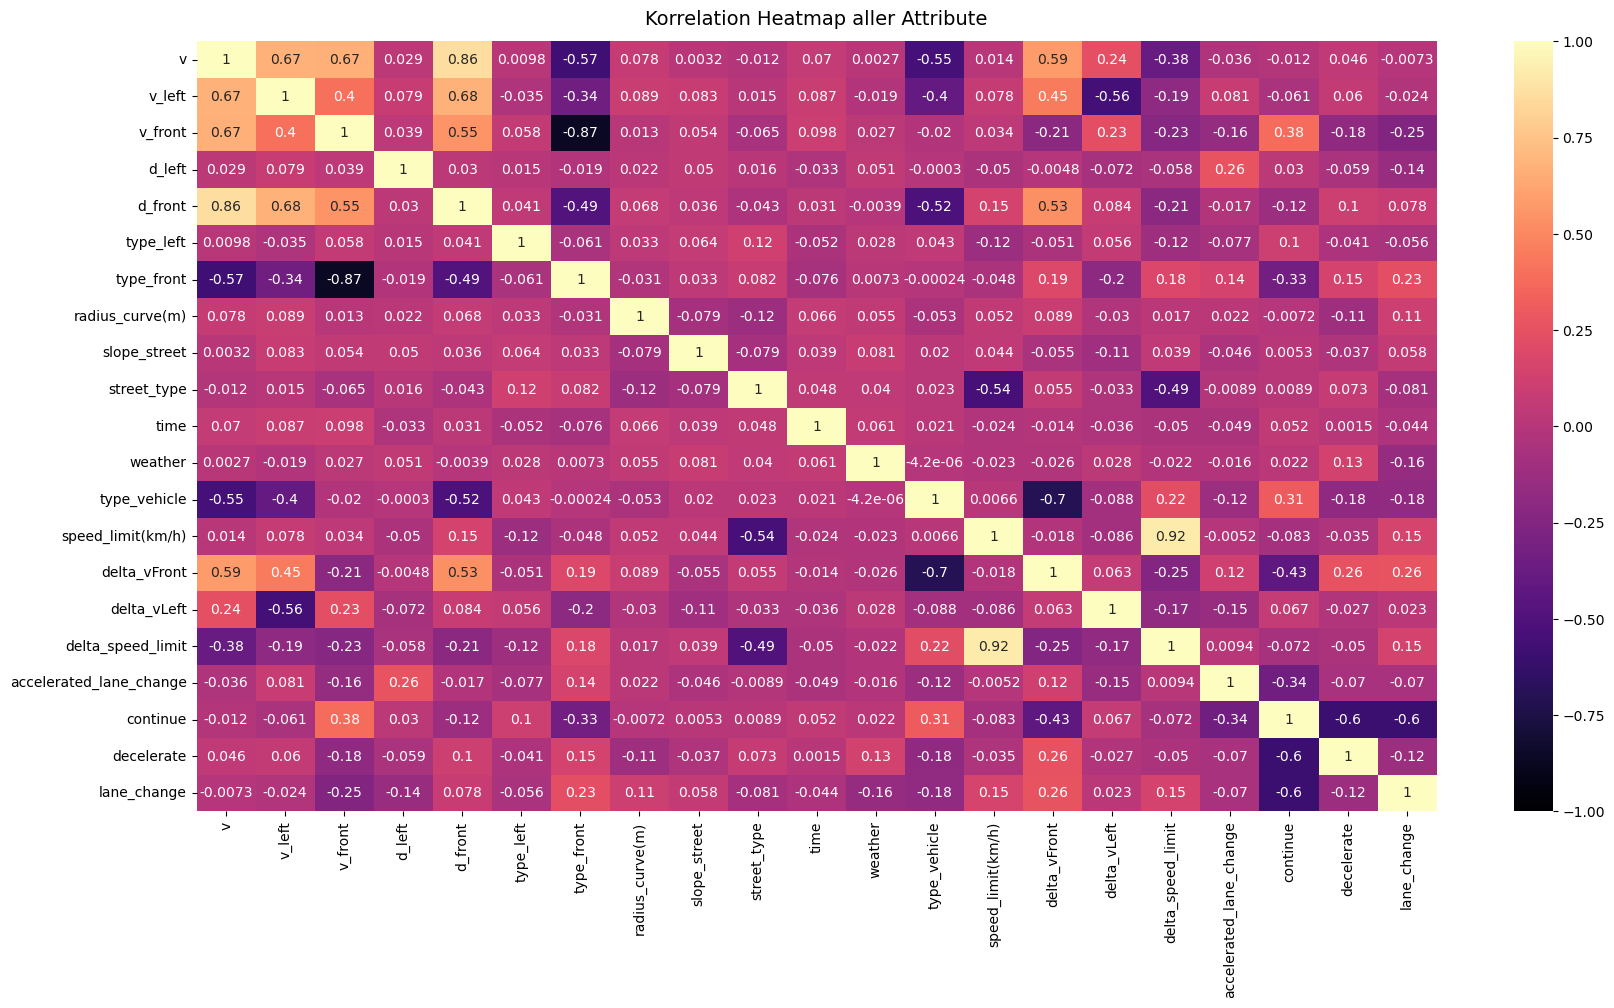

In [182]:
plt.figure(figsize=(20, 10))
sns.heatmap(data=df_analysis.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap="magma").set_title('Korrelation Heatmap aller Attribute', fontdict={'fontsize': 14}, pad=12)

### Evaluation der Korrelationsheatmap
Da die Geschwindigkeit ein zentraler Faktor in der Überholungs-Überlegung ist, wird diese zuerst betrachtet. Sie korreliert in der Heatmap sehr stark mit ``v_left``, ``v_front`` und ``d_front``. Außerdem ist auffällig, dass eine negative Korrelation mit ``type_front`` und ``type_vehicle`` besteht. Diese kann aber wegen nicht vorhandener Rangordnung in den Attributen allerdings nicht in Betracht gezogen werden. 

``type_front`` korreliert zwar mit `v`, `v_left`, `v_front` und `d_front` negativ, allerdings ist auch hier keine Nominalskala vorhanden.

Der wichtigste Faktor für das Training ist ``action``. Dieser Wert teilt sich hier in vier verschiedene Attribute auf. Es ist eine leichte Korrelation zwischen der ``action`` 'continue' und ``v_front`` zu erkennen. Vermutlich wird also eher 'continue' gewählt, wenn der Abstand zum vorrausfahrenden Auto größer ist. 
``v_front`` korreliert außerdem auch leicht negativ mit den anderen ``action``s, dabei am stärksten mit ``lane_change``. Also je kleiner der Abstand zum vorrausfahrenden Auto ist, desto eher wird abgebremst, Spur gewechselt oder beschleunigt die Spur gewechselt.

Außerdem ist zwischen ``accelerated_lane_change`` und ``d_left`` eine leichte Korrelation zu erkennen. Je weiter das Auto auf der linken Spur also entfernt ist, desto größer ist die Wahrscheinlichkeit für einen beschleunigten Spurwechsel. 


### Trainings- und Testdaten aufteilen

Die Daten werden hier aufgeteilt. Um später eine Cross-Validierung möglich zu machen, werden je nach Eingabe verschiedene Intervalle gewählt. Diese sind entweder mit den Testdaten bei 0 - 100, 100 - 200 etc.

In [183]:
# interval got to be between 0 and 4
def get_test_and_train_data(interval):
    lower_border = interval * 100
    upper_border = lower_border + 100
    if lower_border != 0:
        train_data = df_all.loc[:lower_border]
        train_data = train_data.append(df_all.loc[(upper_border+1):])
        test_data = df_all.loc[(lower_border + 1):upper_border]
    else:
        train_data = df_all.loc[(upper_border):]
        test_data = df_all.loc[(lower_border):upper_border-1]
    return train_data, test_data

## Prüfung auf Gleichheit 
In dieser Funktion werden die Testdaten auf Gleichheit überprüft. Das bedeutet, dass die Eingabe mit allen Trainingsdaten verglichen wird und auf eine Überseinstimmung untersucht wird. Sobald Trainingsdaten mit den exakt gleichen Werten gefunden wurden, wird die gleiche 'action' für die Testdaten übernommen.

In [184]:
def check_for_same(input, train_data):
    for index, row in train_data.iterrows():
        if input['v'] == row['v'] and input['v_left'] == row['v_left'] and input['v_front'] == row['v_front'] and input['d_left'] == row['d_left'] and input['d_front'] == row['d_front'] and input['type_left'] == row['type_left'] and input['type_front'] == row['type_front'] and input['radius_curve(m)'] == row['radius_curve(m)'] and input['slope_street'] == row['slope_street'] and input['street_type'] == row['street_type'] and input['time'] == row['time'] and input['weather'] == row['weather'] and input['type_vehicle'] == row['type_vehicle'] and input['speed_limit(km/h)'] == row['speed_limit(km/h)'] and input['delta_vFront'] == row['delta_vFront'] and input['delta_vLeft'] == row['delta_vLeft']:
            return True, row
    return False, 0

## Prüfung auf Ähnlichkeit

Nachdem auf Gleichheit geprüft wurde und der Fall auftritt, dass keine genau gleichen Trainingsdaten gefunden wurden, wird auf Ähnlichkeit geprüft. 
Das heißt, dass alle Attribute verglichen werden und nach dem ähnlichsten Fall in den Trainingsdaten gesucht wird. 

Um am Schluss eine Formel für das Ähnlichkeitsmaß aufstellen zu können, müssen die verschiedenen Attribute alle einen Wert bekommen, der in dem Bereich von 0 und 1 liegt. 

In [185]:
# Similarity of speed with a value between 0 and 1 
# default and to_compare are the input and training data
# both, default and to_compare, contains positive values 
def similarity_v(default, to_compare):
    return 1 - ((abs(default - to_compare))/(abs(default) + abs(to_compare)))

def similarity_v_left(default, to_compare):
    return similarity_v(default, to_compare)

def similarity_v_front(default, to_compare):
    return similarity_v(default, to_compare)

# d_left contains negative values as well and therefore a different actions are necessary
def similarity_d_left(default, to_compare):
    if default == 0 and to_compare == 0: # both 0 
        return 1
    elif default >= 0 and to_compare >= 0: # both positive 
        return similarity_v(default, to_compare)
    elif default < 0 and to_compare < 0: # both negative 
        return similarity_v(default, to_compare)
    # if one number is negative, take its abs value and keep the distance between the numbers
    elif default < 0 and to_compare >= 0:
        default = abs(default)
        to_compare += 2 * default
        return similarity_v(default, to_compare)
    elif default >= 0 and to_compare < 0:
        to_compare = abs(to_compare)
        default += 2 * to_compare
        return similarity_v(default, to_compare)
    else:
        return 0

# similarity of positive numeric values: 
def similarity_d_front(default, to_compare):
    return similarity_v(default, to_compare)

def similarity_radius_curve(default, to_compare):
    return similarity_v(default, to_compare)

def similarity_speed_limit(default, to_compare):
    return similarity_v(default, to_compare)

def similarity_delta_vFront(default, to_compare):
    return similarity_v(default, to_compare)

# similarity of mixed numeric values -> therefore similarity_d_left is necessary
def similarity_delta_vLeft(default, to_compare):
    return similarity_d_left(default, to_compare)

def similarity_delta_speed_limit(default, to_compare):
    return similarity_d_left(default, to_compare)

### Distanzberechnung der type_left, type_front und type_vehicle Fahrzeuge
0: motorcycle and truck<br>
0.1: sportscar and truck<br>
0.3: car and motorcycle<br>
0.5: sportscar and motorcycle<br>
0.6: car and truck<br>
0.8: car and sportscar<br>
1: same<br>

In [186]:
# 0 = car, 1 = motorcycle, 2 = sportscar, 3 = truck
def similarity_type_left(default, to_compare):
    if (default == 1 and to_compare == 3) or (default == 3 and to_compare == 1): # motorcycle and truck
        return 0.0
    if (default == 2 and to_compare == 3) or (default == 3 and to_compare == 2): # sportscar and truck
        return 0.1
    if (default == 0 and to_compare == 1) or (default == 1 and to_compare == 0): # car and motorcycle
        return 0.3
    if (default == 2 and to_compare == 1) or (default == 1 and to_compare == 2): # sportscar and motorcycle
        return 0.5
    if (default == 0 and to_compare == 3) or (default == 3 and to_compare == 0): # car and truck
        return 0.6
    if (default == 0 and to_compare == 2) or (default == 2 and to_compare == 0): # car and sportscar
        return 0.8    
    if (default == to_compare): # same
        return 1.0

# same vehicles and encodings 
def similarity_type_front(default, to_compare):
    return similarity_type_left(default, to_compare)

# same vehicles and encodings 
def similarity_type_vehicle(default, to_compare):
    return similarity_type_left(default, to_compare)

### Distanzberechnung der Routenbeschaffenheit


In [187]:
# ascending = 0, descending = 1, flat = 2
def similarity_slope_street(default, to_compare):
    if (default == 1 and to_compare == 2) or (default == 2 and to_compare == 1): # descending and flat
        return 0.5
    elif (default == 0 and to_compare == 2) or (default == 2 and to_compare == 0): # ascending and flat
        return 0.5
    elif default == to_compare:
        return 1
    else:
        return 0   

### Distanzberechnung der Straßenart 

In [188]:
# to different types of streets 
# same -> 1 
# different (autobahn and country_road) -> 0
def similarity_street_type(default, to_compare):
    if default == to_compare:
        return 1
    else:
        return 0

### Distanzberechnung für das Wetter
0.0: dry and snow ice<br>
0.1: fog and snow ice<br>
0.1: rain and snow ice<br>
0.5: dry and fog<br>
0.6: fog and rain<br>
0.8: dry and rain<br>
1: same<br>

In [189]:
# dry = 0, fog = 1, rain = 2, snow_ice = 3 
def similarity_weather(default, to_compare):
    if (default == 0 and to_compare == 3) or (default == 3 and to_compare == 0): # dry and snow-ice 
        return 0
    if (default == 1 and to_compare == 3) or (default == 3 and to_compare == 1): # fog and snow-ice 
        return 0.1
    if (default == 2 and to_compare == 3) or (default == 3 and to_compare == 2): # rain and snow-ice 
        return 0.1
    if (default == 0 and to_compare == 1) or (default == 1 and to_compare == 0): # dry and fog 
        return 0.5
    if (default == 2 and to_compare == 1) or (default == 1 and to_compare == 2): # fog and rain
        return 0.6
    if (default == 2 and to_compare == 0) or (default == 0 and to_compare == 2): # dry and rain
        return 0.8
    if (default == to_compare): # same
        return 1.0

### Distanzberechnung für die verschiedenen Tageszeiten
0: day and night<br>
0.4: dusk and night<br>
0.5: dawn and night<br>
0.5: day and dawn<br>
0.6: day and dusk<br>
0.8: dawn and dusk<br>
1: same<br>

In [190]:
# dawn = 0, day = 1, dusk = 2, night = 3
def similarity_time(default, to_compare):
    if (default == 1 and to_compare == 3) or (default == 3 and to_compare == 1): # day and night
        return 0.0
    if (default == 2 and to_compare == 3) or (default == 3 and to_compare == 2): # dusk and night
        return 0.4
    if (default == 0 and to_compare == 3) or (default == 3 and to_compare == 0): # dawn and night
        return 0.5
    if (default == 0 and to_compare == 1) or (default == 1 and to_compare == 0): # day and dawn
        return 0.5
    if (default == 1 and to_compare == 2) or (default == 2 and to_compare == 1): # day and dusk
        return 0.6
    if (default == 0 and to_compare == 2) or (default == 2 and to_compare == 0): # dawn and dusk
        return 0.8    
    if (default == to_compare): # same
        return 1.0

### Das ähnlichste Element finden
Zuerst werden die Gewichtungen für jedes einzelne Attribut festgelegt. Anschließend wird die Ähnlichkeit (similarity) berechnet. Dies funktioniert über Gewichtung * Ähnlichkeit, beide Werte zwischen null und eins. Anschließend werden die gewichteten Ähnlichkeiten aller Attribute aufsummiert und mit dem bisher ähnlichsten Fall verglichen. Wenn neue Fall ein höheres Ähnlichkeitsmaß erreicht, wird er selbst zum bisher höchsten gefundenen. Am Ende der Schleife wird die in dem Moment ähnlichste Situation zurückgegeben.  

### Die Gewichtung
Bei der Gewichtung wurden verschiedene Gedankengänge und Ansätze kombiniert. Angefangen wurde mit jedem Gewicht auf eins. Es wurde damit weitergemacht, die Korrelationen aus der Korrelationsheatmap zu interpretieren und die Gewichtungen dort anzupassen, wo Auffälligkeiten gefunden wurden. Dies kann am Beispiel von delta_speed_limit gesehen werden. In der Heatmap ist zu erkennen, dass es mit keiner Option von ``Action`` stark korreliert. Die genauen Werte sind 0.0094 (accelerated_lane_change), -0.072 (continue), -0.05 (decelerate) und 0.15 (lange_change). Es wurde also die Gewichtung von ``delta_speed_limit`` verringert. Bei diesem Schritt der Korrelationen auf die Gewichtungen zu übertragen ist es wichtig, dass Scheinkorrelationen ausgelassen werden. Ein Beispiel hierfür ist `type_vehicle`. Es handelt sich hier um keine Nominalskala, Korrelationen sind also prinzipiell nicht aussagekräftig. Trotzdem ergeben sich für die vier Optionen von `Action` die folgenden Werte: -0.12 (accelerated_lane_change), 0.31 (continue), -0.18 (decelerate) und -0.18 (lange_change). 

Nach dem diese ersten Gewichtungen eingestellt wurden, folgte eine persönliche Einschätzung der Gewichtungen einzelner Attribute. Dies geschah vor allem für Attribute, welche über welche die Korrelation nichts ausgesagt hat. Beispielhaft zu nennen sind hierfür `street_type`, `slope_street`, und `time`. Z.B. bei `street_type` existieren nur zwei verschiedene Optionen, welche sich nicht groß zu unterscheiden scheinen, darum wurde es heruntergestuft.

Als letzten Schritt wurde mithilfe der Accuracy versucht, die einzelnen Attribute mittels anderer Gewichtungen auszuprobieren anzupassen. Es wurde also immer die Gewichtung eines einzelnen Attributes verändert, die Accuracy berechnet und abhängig von ihrer Veränderung die Gewichtung des Attributes weiter angepasst. Ging die Accuracy eindeutig hoch, wurde die Gewichtung erhöht. Veränderte sich die Accuracy allerdings nicht, wurde eine niedrigere Gewichtung gewählt, da das Attribut scheinbar kein großen Einfluss auf die Vorhersage hat. Trotz allem wurde minimal eine Gewichtung von 10% gewählt, um dennoch keine Attribute vollständig auszulassen. Dies wäre zwar denkbar, allerdings wird die Vorhersage in diesem Fall weniger konstant. Die Evaluation der einzelnen Testdatenintervalle zeigt, dass diese sich deutlich stärker voneinander unterscheiden. Da die durchschnittliche Accuracy sich allerdings nahezu nicht verändert, wurden alle minimalen Gewichtungen auf 0.1 gesetzt. Allgemein wurde für jedes Attribut ausprobiert, wie sehr sich mit seiner Gewichtung auch die Accuracy ändert, auch für in Schritt eins und zwei bereits angepasste Gewichtungen. Oftmals konnte bei diesen bereits angepassten Gewichtungen aber festgestellt werden, dass sie schon gut angepasst waren (Bspw. bei `delta_speed_limit` aus Schritt 1 und `street_type` aus Schritt 2). Überraschend in diesem Schritt war, dass für `v_front` ein geringeres Gewicht zu einer höheren Accuracy führt. Es wurde eigentlich davon ausgegangen, dass dieses Attribut wichtig für die vorhergesagten `Action` ist. Mit `delta_vLeft` verhielt es sich genau so, auch hier wurde fälschlicherweiße erwartet, dass eine höhere Gewichtung zu einer besseren Performance führt.

In [191]:
# try to find the most similar case 
def check_for_similar(input, train_data):
    # weights setting:
    weight_v = 1
    weight_v_left = 1
    weight_v_front = 0.4
    weight_d_left = 1
    weight_d_front = 1
    weight_type_left = 0.1
    weight_type_front = 0.1
    weight_radius_curve = 0.7
    weight_slope_street = 0.1
    weight_street_type = 0.1
    weight_time = 0.1
    weight_weather = 0.8
    weight_type_vehicle = 0.1
    weight_speed_limit = 1
    weight_delta_vFront = 0.8
    weight_delta_vLeft = 0.4
    weight_delta_speed_limit = 0.2

    max_sim = 0
    max_row = 0

    # comparing attributes from training_data and input 
    for i in range(len(train_data)):
        row = train_data.iloc[i]
        # similarity calculation 
        similarity = weight_v * similarity_v(input['v'], row['v'])\
        + weight_v_left * similarity_v_left(input['v_left'], row['v_left']) \
        + weight_v_front * similarity_v_front(input['v_front'], row['v_front']) \
        + weight_d_left * similarity_d_left(input['d_left'], row['d_left'])  \
        + weight_d_front * similarity_d_front(input['d_front'], row['d_front'])  \
        + weight_type_left * similarity_type_left(input['type_left'], row['type_left'])  \
        + weight_type_front * similarity_type_front(input['type_front'], row['type_front']) \
        + weight_radius_curve * similarity_radius_curve(input['radius_curve(m)'],row['radius_curve(m)']) \
        + weight_slope_street * similarity_slope_street(input['slope_street'], row['slope_street']) \
        + weight_street_type * similarity_street_type(input['street_type'], row['street_type']) \
        + weight_time * similarity_time(input['time'], row['time']) \
        + weight_weather * similarity_weather(input['weather'], row['weather']) \
        + weight_type_vehicle * similarity_type_vehicle(input['type_vehicle'], row['type_vehicle']) \
        + weight_speed_limit * similarity_speed_limit(input['speed_limit(km/h)'], row['speed_limit(km/h)']) \
        + weight_delta_vFront * similarity_delta_vFront(input['delta_vFront'], row['delta_vFront']) \
        + weight_delta_vLeft *  similarity_delta_vLeft(input['delta_vLeft'], row['delta_vLeft']) \
        + weight_delta_speed_limit * similarity_delta_speed_limit(input['delta_vFront'], row['delta_vFront'])
        if similarity > max_sim: # if current similarity bigger than the previous one, use the current row 
            max_row = row
            max_sim = similarity
        
     # use highest similarity and the corresponding action for return
    return max_row

### Vorhersage der Action
Es wird zuerst geschaut, ob ein gleicher Fall in den Daten gefunden wird. Falls dies der Fall ist, wird sich gleich verhalten wie in dem gefundenen Fall. Wenn kein identischer Fall vorhanden ist, wird mit ``check_for_similar`` nach dem ähnlichsten Fall gesucht. Es wird sich dann so verhalten, wie in dem gefundenen Fall. Für bessere Nachvollziehbarkeit kann die Flag ``print_output`` genutzt werden.

In [192]:
def do_prediction(input, train_data, print_output = False):
    # first check for equal data 
    success, prediction = check_for_same(input, train_data)
    # if no matching data was found -> check for the most similar case 
    if not success:
        prediction = check_for_similar(input, train_data)
    # debug mode
    if print_output:
        print('Input: \n', input)
        print("\n-Prediction-\n")
        print('Prediction: \n', prediction)
    return prediction['action']

# input prediction:
for i in range(0, len(df_input)):
    print('Predicted action for input case nr. ', str(i+1), ': ', do_prediction(df_input.iloc[i], df_all, print_output=False), ' \t\t Real action: ', df_input.iloc[i]['action'])


Predicted action for input case nr.  1 :  continue  		 Real action:  continue
Predicted action for input case nr.  2 :  continue  		 Real action:  continue
Predicted action for input case nr.  3 :  decelerate  		 Real action:  decelerate
Predicted action for input case nr.  4 :  continue  		 Real action:  continue


### Berechnung der Accuracy

Dabei wird die Genauigkeit des Modells berechnet, indem alle mittels Cross-Validation die fünf Durchläufe mit den unterschiedlichen Test- und Trainingsdaten aufsummiert werden und dann durch die Länge, also die Anzahl der Durchläufe, geteilt wird. 

Außerdem wird nach der Suche einer Eingabe, die Eingabe und die Lösung des ähnlichen Falls aus den Trainingsdaten weiter verwendet. Dafür werden die Daten dem Trainingsdatensatz hinzugefügt. 

In [193]:
import warnings
warnings.filterwarnings('ignore')

def evaluate_accuracy(add_test_line = False):
    accuracy_sum = []
    for j in range(0,5):
        train_data, test_data = get_test_and_train_data(j)
        accuracy = 0
        for i in range(len(test_data)):
            row = test_data.iloc[i]
            prediction = do_prediction(row, train_data)
            if prediction == row['action']:
                accuracy += 1
            # Retain phase
            if add_test_line:
                train_data = train_data.append(row)
        accuracy = accuracy / len(test_data)
        print('accuracy ', str(j+1), ' is: ', accuracy, ' / ', len(test_data))
        accuracy_sum.append(accuracy)
    accuracy_average = np.sum(accuracy_sum)/len(accuracy_sum)
    print('accuracy total: ', accuracy_average)
evaluate_accuracy(False)


accuracy  1  is:  0.8  /  100
accuracy  2  is:  0.78  /  100
accuracy  3  is:  0.85  /  100
accuracy  4  is:  0.81  /  100
accuracy  5  is:  0.87  /  100
accuracy total:  0.8220000000000001


## Ergebnisbewertung

Bei der Untersuchung der Daten für unser Modell ist uns aufgefallen, dass die Daten vermehrt eine für uns nicht nachvollziehbare Schlussfolgerung der 'action' aufweisen. 
Beispiele die dies verdeutlichen sind unter anderem: 
* Beschleunigen (``accelerate``), obwohl das Fahrzeug schon 140 km/h fährt und zusätzlich bereits über dem speed limit ist. 
* Überholen (``lane_change``), obwohl das Fahrzeug auf der linken Seite sehr schnell angefahren kommt und es knapp ist auszuscheren.
* Geschwindigkeit und Spur beibehalten (``continue``), obwohl das Fahrzeug sich bereits sehr nah an dem vorderen Fahrzeug befindet und schneller fährt als dieses. 
Durch diese interessanten Entscheidungen in den vorgegebenen Daten, kommen teilweise überraschende Ergebnisse für neue Testdaten heraus. Der Grund dafür liegt darin, dass das Modell auf dem Cased Based Reasoning basiert und somit nach möglichst ähnlichen Fällen schaut und anschließend deren 'action' übernimmt.

Außerdem haben die Gewichtsanpassungen der einzelnen Attribute einen hohen Einfluss auf die Genauigkeit des Modells und der Vorhersage. Dabei haben uns einige Attribute und deren Einfluss auf die Ähnlichkeit überrascht, da sie teilweise mehr Einfluss haben, als wir vermutet hatten (z.B. ``radius_curve`` und ``weather``). 

Einen hohen Einfluss auf das Ergebnis des Modells hat auch das Festlegen der Ähnlichkeitsmaße für die Attribute. Den hierbei wird das Verhältnis einzelner Objekte zueinander bewertet und deren Ähnlichkeit beurteilt. Wird dabei etwas anders eingestuft, als es der Wahrheit entspricht, können Werte verfälscht werden. Für eine bessere Bewertung könnte in der Optimierung des Modells Expertenwissen mit einbezogen werden.

Bei der Betrachtung der berechneten Accuracy fällt auf, dass der fünfte Wert am höchsten ist. Das liegt daran, dass die Hyperparameteroptimierung ausschließlich mit Trainingsdaten aus Bereich 5 stattgefunden hat, und es somit zum Overfitting in diesem Bereich kommt. Das heißt, das Modell macht damit sehr gute Vorhersagen für die Daten im Bereich 5, aber tendenziell weniger für neue Daten. 
Eine genaue Anpassung auf alles Bereiche und Daten haben wir nicht gemacht, da es sehr rechen- und zeitaufwendig ist, dieses mit der Cross-Validation zu machen. Außerdem gibt es immer eine leicht ungleiche Verteilung.


## Fazit

Abschließend lässt sich sagen, dass die Vorhersage der Aktion des Fahrzeuges eine gute Vorhersage-Genauigkeit besitzt. Die teilweise etwas unrealistischen Vorhersagen lassen sich damit erklären, dass ähnliche Daten in dem Trainingsdatensatz enthalten sind und diese eine solche 'action' besitzen. 

Die erreichte Accuracy könnte dennoch besser sein, allerdings ist es aufgrund der geringen Anzahl an Trainingsdaten nicht möglich, die Vorhersage zu verbessern, ohne in den Overfitting-Bereich zu geraten. 